**Table of contents**<a id='toc0_'></a>    
- [A*によるグローバルパスプランニング](#toc1_)    
  - [参考サイト](#toc1_1_)    
- [pybulletの起動](#toc2_)    
- [初期設定](#toc3_)    
- [環境地図の作成](#toc4_)    
  - [障害物を生成、環境地図を作成する関数の定義](#toc4_1_)    
  - [障害物の生成、環境地図の作成](#toc4_2_)    
- [A*クラスの定義](#toc5_)    
- [A*の実行](#toc6_)    
- [おまけ：アニメーションの表示](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Global Path Planning with A*](#toc0_)

This notebook explains A*.

(For a manual summarizing the functions available in pybullet, please refer to [here](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf).)

A* is one of the methods for "global path planning" and is an algorithm that searches for the shortest path from the start point to the goal point.

In general, global path planning alone is rarely used for planning and is often combined with "local path planning" methods such as DWA.

<br>

Specifically,

1. Global path planning is used to plan a global path from the initial point to the target point.

<img src="../images/MobileRobot/mobile_robot_local_path_planning_dwa/global_path_planning.png" width="50%">


<br>
<br>

2. The global path planned by global path planning is divided into several intermediate points, and local path planning is used to sequentially travel from "intermediate point 1" to "intermediate point 2" to "intermediate point 3" to ... to "target point".

<img src="../images/MobileRobot/mobile_robot_local_path_planning_dwa/local_path_planning.png" width="50%">

In the case of local path planning, the target point is reached while considering the surrounding environment in real-time.  
Therefore, if obstacles move slightly, it is possible to reach the target point while avoiding obstacles without re-planning the global path.


# <a id='toc2_'></a>[Starting pybullet](#toc0_)

In [1]:
import pybullet
import pybullet_data
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 15.0.7, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 15.0.7, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


# <a id='toc3_'></a>[Initial Settings](#toc0_)

Set up the environment and generate the robot.

In [2]:
import math

pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add the path to the necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity to Earth's gravity
time_step = 0.1
pybullet.setTimeStep(time_step) # Set the time elapsed per step

# Reset the simulation space
pybullet.resetSimulation() 

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the robot
car_start_pos = [0.5, 0.5, 0.1]  # Set the initial position (x, y, z)
car_start_yaw = math.radians(0)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, car_start_yaw]) # Convert the initial orientation (roll, pitch, yaw) to a quaternion
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position for GUI mode
camera_distance = 6.0
camera_yaw = 180.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [3.0, 3.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

ven = Mesa
ven = Mesa


# <a id='toc4_'></a>[Creating the Environment Map](#toc0_)

In path planning for mobile robots in a 2D plane, it is common to create an environment map and plan the robot's path on that map.

Here, we will generate obstacles in pybullet and create an environment map that reflects the obstacle information.

In this case, we generate walls of the size specified by `wall_size` and use that area as the environment map.

The environment map is created as a grid map with each cell size specified by `m_per_pixel`.
- The smaller the `m_per_pixel`, the finer the grid map, improving accuracy but increasing the computational load during path planning.
- Conversely, the larger the `m_per_pixel`, the coarser the grid map, reducing accuracy but decreasing the computational load, allowing for faster path planning.

<img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/obstacle_real_to_map.png" width="80%">

<br>

By expanding the obstacles by the "robot radius `robot_radius`", the mobile robot can be treated as a point during path planning.

* Treating the mobile robot as a point allows for efficient collision detection during path planning.

<img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/obstacle_expansion.png" width="50%">

## <a id='toc4_1_'></a>[Definition of Functions to Generate Obstacles and Create Environment Map](#toc0_)

In [3]:
# Jupyter Notebook用の設定
%matplotlib inline
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

def create_wall(wall_size, wall_thickness, wall_height):
    """
    pybullet上に四方を囲む壁を作成

    Args:
    wall_size (float): 壁の一辺の長さ
    wall_thickness (float): 壁の厚さ
    wall_height (float): 壁の高さ
    """
    wall_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[wall_size/2, wall_thickness/2, wall_height/2])
    wall_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[wall_size/2, wall_thickness/2, wall_height/2], rgbaColor=[0.5,0.5,0.5,1])
    wall_ids = []
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size/2, -wall_thickness/2, wall_height/2]))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size/2, wall_size+wall_thickness/2, wall_height/2]))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [-wall_thickness/2, wall_size/2, wall_height/2], pybullet.getQuaternionFromEuler([0, 0, math.pi/2])))
    wall_ids.append(pybullet.createMultiBody(0, wall_collision_id, wall_visual_id, [wall_size+wall_thickness/2, wall_size/2, wall_height/2], pybullet.getQuaternionFromEuler([0, 0, math.pi/2])))
    return wall_ids

def create_obstacle(box_size_min, box_size_max, obstacle_num, wall_size):
    """
    pybullet上にランダムな障害物（立方体）を作成

    Args:
    box_size_min (float): 障害物の最小サイズ
    box_size_max (float): 障害物の最大サイズ
    obstacle_num (int): 障害物の数
    wall_size (float): 壁の一辺の長さ
    """
    #　左下を原点とした座標系の中で、壁の範囲内にランダムに障害物を配置
    obstacles = []
    for _ in range(obstacle_num):
        box_size = random.uniform(box_size_min, box_size_max)
        x = random.uniform(0+box_size, wall_size-box_size)
        y = random.uniform(0+box_size, wall_size-box_size)
        yaw = random.uniform(0, math.pi)
        obstacles.append([box_size, x, y, yaw])

    # pybullet上に障害物を配置 
    obstacles_id = []
    for obstacle in obstacles:
        box_size = obstacle[0]
        x = obstacle[1]
        y = obstacle[2]
        yaw = obstacle[3]
        obstacle_id = pybullet.loadURDF("../urdf/simple_box.urdf", [x, y, box_size/2], pybullet.getQuaternionFromEuler([0,0,yaw]), globalScaling=box_size*2, useFixedBase=True)
        obstacles_id.append(obstacle_id)
        pybullet.changeVisualShape(obstacle_id, -1, rgbaColor=[1, 0, 0, 1])
    return obstacles, obstacles_id

def draw_wall(environment_image):
    """
    四方を囲む壁を描画

    Args:
    environment_image (np.array): 環境の画像
    """
    # 壁の領域を0で塗りつぶす
    environment_image[0, :] = 0
    environment_image[-1, :] = 0
    environment_image[:, 0] = 0
    environment_image[:, -1] = 0


def draw_obstacle(obstacles, environment_image, m_per_pixel, robot_radius):
    """
    障害物を描画

    Args:
    obstacle (list): 障害物の情報 [box_size, x, y, yaw]
    environment_image (np.array): 環境の画像
    m_per_pixel (float): 1ピクセルあたりのメートル数
    robot_radius (float): ロボットの半径
    """
    # 障害物の領域を0で塗りつぶす
    for obstacle in obstacles:

        # 移動ロボットの大きさ分だけ障害物を大きくすることで
        # 移動ロボットを点として扱うことが可能となり、経路計画の際の衝突判定を行いやすくなる
        box_size = obstacle[0] + robot_radius  

        # 地図座標系における障害物の大きさ、位置、角度を計算
        box_size_map = int(box_size * (1/m_per_pixel))
        x = int(obstacle[1]*(1/m_per_pixel))
        y = int(obstacle[2]*(1/m_per_pixel))
        yaw = obstacle[3]

        # 障害物の4つの頂点を計算
        corners = np.array([[-box_size_map, box_size_map, box_size_map, -box_size_map, -box_size_map],
                            [-box_size_map, -box_size_map, box_size_map, box_size_map, -box_size_map]])
        R = np.array([[math.cos(yaw), -math.sin(yaw)], [math.sin(yaw), math.cos(yaw)]])
        rotated_corners = R @ corners
        rotated_corners[0] += x
        rotated_corners[1] += y
        
        # 障害物の頂点を結んだ線を描画
        for i in range(4):
            cv2.line(environment_image, (int(rotated_corners[0][i]), int(rotated_corners[1][i])), (int(rotated_corners[0][i+1]), int(rotated_corners[1][i+1])), 0, 2)


## <a id='toc4_2_'></a>[障害物の生成、環境地図の作成](#toc0_)

以下変数を変更することで、異なる環境地図を作成することができます。
- `wall_size` : 四方を囲む壁のサイズ（この壁の中で経路計画を行う）
- `obstacle_num` : 生成する障害物の数
- `box_size_min` : 障害物の最小サイズ
- `box_size_max` : 障害物の最大サイズ（最小サイズと最大サイズの間でランダムなサイズの立方体を生成）
- `m_per_pixel` : グリッドマップの1セルのサイズ（単位：m）
- `robot_radius` : ロボットの半径（単位：m）
  - ロボットの半径分だけ、障害物が膨張されます。


※ デフォルトでは、`random.seed(10)`で乱数のシードを固定しているため、同じ環境地図が生成されます。

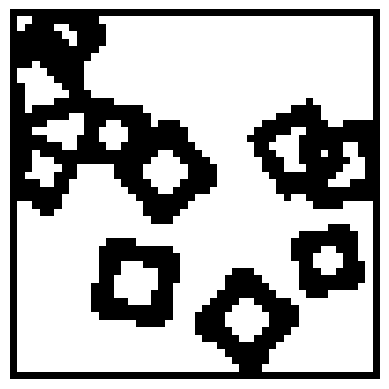

In [4]:
# Set random seed
random.seed(10)

# Remove existing obstacles
if vars().get('wall_ids') is not None:
    for wall_id in wall_ids:
        pybullet.removeBody(wall_id)
if vars().get('obstacles_id') is not None:
    for obstacle_id in obstacles_id:
        pybullet.removeBody(obstacle_id)

# Create walls surrounding the area
wall_size = 5
wall_thickness = 0.1
wall_height = 0.5
wall_ids = create_wall(wall_size, wall_thickness, wall_height)

# Create a list of obstacle box sizes and positions ([box_size, box_size], [x, y, yaw])
obstacle_num = 10
box_size_min = 0.1
box_size_max = 0.3
obstacles, obstacles_id = create_obstacle(box_size_min, box_size_max, obstacle_num, wall_size)

# Create an environment map image based on the generated objects in pybullet
m_per_pixel = 0.1  # Meters per pixel
robot_radius = 0.2  # Robot radius
image_size = int(wall_size * (1/m_per_pixel))
environment_image = np.full((image_size, image_size), 255, dtype=np.uint8)
draw_wall(environment_image)
draw_obstacle(obstacles, environment_image, m_per_pixel, robot_radius)

# Display the created environment map
# Flip the image to make the top-left the origin
environment_image = cv2.flip(environment_image, 0)
# Hide the axes
plt.axis('off')
plt.imshow(environment_image, cmap='gray')

# <a id='toc5_'></a>[Definition of A* Class](#toc0_)

A* is an algorithm that searches for the shortest path from the start point to the goal point.

The general procedure is as follows:

1. Initialization
   - Initialization is done in the `__init__` method.

<br>

2. Create a "node map `nodes_map`" based on the "environment map `environment_map`".  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/nodes_map.png" width="80%">
   - Each node has the following information:
     - `x_map`: x-coordinate of the node
     - `y_map`: y-coordinate of the node
     - `cost_start_to_node`: Cost from the start point to the node. The initial value is set to infinity and is updated each time the shortest distance is found during the search.
     - `cost_node_to_goal`: Cost from the node to the goal point. Since the actual cost from the node to the goal point is unknown during the search, the "Euclidean distance from the node to the goal point" is set as the cost.
       - Since it is an estimated (heuristic) cost, it differs from the actual cost.
       - For example, if there is an obstacle on the straight line, the actual cost will be greater than `cost_node_to_goal` because it will detour to avoid the obstacle.
     - Summarizing the two costs, it looks like the following figure.
         <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/cost_example.png" width="80%"> 
     - `is_obstacle`: Whether the node is on an obstacle
     - `parent`: Parent node
     - `is_explored`: Whether the node has been explored


3. Set the `cost_start_to_node` of the start node to 0.

4. Select the node with the minimum `cost_start_to_node` among the nodes with `is_explored` as False (under exploration).

5. Set the `is_explored` of the selected node (hereafter referred to as the current node) to True (explored).

6. Calculate the "new cost from the start to the surrounding nodes `cost_start_to_node_new`" for the "8 surrounding pixels of the current node (surrounding nodes)".  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/next_node.png" width="30%">
   - Specifically, calculate "`cost_start_to_node_new` = `nodes_map[x_map_current][y_map_current].cost_start_to_node` + distance from the current node to the surrounding node".  
   <img src="../images/MobileRobot/mobile_robot_global_path_planning_a_star/next_node_cost.png" width="100%">

<br>

7. If "`cost_start_to_node_new`" < "surrounding node's `cost_start_to_node`"
   - Update the surrounding node's `cost_start_to_node` to `cost_start_to_node_new`,
   - Set the surrounding node's `parent` to the current node.

8. Repeat steps 3 to 6 until the goal point is reached.


In the following code, to distinguish between "real-world coordinates" and "map coordinates," the variable names are set as follows:
- `x_real`, `y_real`: Real-world coordinates
- `x_map`, `y_map`: Map coordinates


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class MapNode:
    def __init__(self, x_map, y_map):
        """
        Node on the map
        Attributes
        ----------
        x_map : int
            x-coordinate of the node (map coordinate system)
        y_map : int
            y-coordinate of the node (map coordinate system)
        cost_start_to_node : float
            Cost from start to node
                Set the "shortest distance actually explored and found" from start to node as the cost (initial value is infinity)
        cost_node_to_goal : float
            Cost from node to goal
                Set the "Euclidean distance" from node to goal as the cost
                Since cost_node_to_goal is a heuristic cost, it differs from the actual cost
                For example, if there is an obstacle between the straight line, the actual cost will be greater than the Euclidean distance
        parent : MapNode
            Parent node
        is_obstacle : bool
            Whether there is an obstacle
        is_explored : bool
            Whether it has been explored
        """
        self.x_map = x_map
        self.y_map = y_map
        self.cost_start_to_node = float("inf")
        self.cost_node_to_goal = float("inf")
        self.is_obstacle = False
        self.parent = None
        self.is_explored = False

class AStar:
    def __init__(self, x_real_start, y_real_start, x_real_goal, y_real_goal, environment_map, m_per_pixel, heuristic_weight, save_animation=False):
        """
        Attributes
        ----------
        x_real_start : float
            x-coordinate of the start point (real coordinate system)
        y_real_start : float
            y-coordinate of the start point (real coordinate system)
        x_real_goal : float
            x-coordinate of the goal point (real coordinate system)
        y_real_goal : float
            y-coordinate of the goal point (real coordinate system)
        environment_map : numpy.ndarray
            Environment map (2D array where obstacles are 0 and passable areas are 255)
        m_per_pixel : float
            Size of the real space per pixel (m/pixel)
        heuristic_weight : float
            Weight of the heuristic
        is_save_map_images : bool
            Whether to save map images (for animation)
        nodes_map : list
            2D array of nodes
        explore_map : numpy.ndarray
            Image for drawing explored nodes (for animation)
        fig : matplotlib.figure.Figure
            Figure for drawing (for animation)
        ax : matplotlib.axes.Axes
            Axes for drawing (for animation)
        image : matplotlib.image.AxesImage
            Image for drawing (for animation)
        """
        self.x_real_start = x_real_start
        self.y_real_start = y_real_start
        self.x_real_goal = x_real_goal
        self.y_real_goal = y_real_goal
        self.environment_map = environment_map
        self.m_per_pixel = m_per_pixel
        self.heuristic_weight = heuristic_weight
        self.is_save_map_images = save_animation
        self.nodes_map = self.create_nodes_map()
        if self.is_save_map_images:
            self.explore_map = self.create_searched_map()
            self.fig, self.ax = plt.subplots(figsize=(self.environment_map.shape[0], self.environment_map.shape[1]), dpi=10)
            self.ax.set_xlim(0, self.environment_map.shape[0])
            self.ax.set_ylim(0, self.environment_map.shape[1])
            self.ax.axis('off')
            self.fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            self.image = self.ax.imshow(self.explore_map, animated=True)
            self.map_image_array = []

    def create_nodes_map(self):
        """
        Create a 2D array of node maps

        Returns
        -------
        nodes_map : list
            2D array of node maps
        """
        goal_x_map, goal_y_map = self.real_to_map(self.x_real_goal, self.y_real_goal)
        # Create a 2D array of nodes_map
        nodes_map = np.empty((self.environment_map.shape[0], self.environment_map.shape[1]), dtype=object)
        for x_map in range(self.environment_map.shape[0]):
            for y_map in range(self.environment_map.shape[1]):
                # Set heuristic cost
                # This time, the heuristic cost is the Euclidean distance from "node[x_map][y_map]" to "node[goal_x_map][goal_y_map]"
                # Therefore, since the heuristic cost is invariant, it is calculated in advance
                # * Here, for clarity, it is calculated in advance, but if the map is large, it consumes a lot of memory, so it is common to calculate it sequentially when necessary in the actual algorithm
                cost_node_to_goal = self.calc_cost_node_to_goal(x_map, y_map, goal_x_map, goal_y_map, self.heuristic_weight)
                nodes_map[x_map][y_map] = MapNode(x_map, y_map)
                nodes_map[x_map][y_map].cost_node_to_goal = cost_node_to_goal
                
                # Set the coordinates of the node
                nodes_map[x_map][y_map].x_map = x_map
                nodes_map[x_map][y_map].y_map = y_map
                
                # Set the presence of obstacles
                if self.environment_map[x_map][y_map] == 0:
                    nodes_map[x_map][y_map].is_obstacle = True
        return nodes_map

    def create_searched_map(self):
        """
        Create a 2D array for drawing explored nodes (for animation)
        """
        searched_map = np.full((self.environment_map.shape[0], self.environment_map.shape[1], 3), 255, dtype=np.uint8)
        return searched_map
        
    def real_to_map(self, x_real, y_real):
        """
        Convert real coordinates to image coordinates

        Parameters
        ----------
        x_real : float
            x-coordinate of the real coordinates
        y_real : float
            y-coordinate of the real coordinates

        Returns
        -------
        x_map : int
            x-coordinate on the image
        y_map : int
            y-coordinate on the image
        """
        x_map = int(x_real / self.m_per_pixel)
        y_map = int(y_real / self.m_per_pixel) # The y-coordinate of the numpy array has the origin at the top left, so invert the y-coordinate
        return x_map, y_map
    
    def map_to_real(self, x_map, y_map):
        """
        Convert image coordinates to real coordinates

        Parameters
        ----------
        x_map : int
            x-coordinate on the image
        y_map : int
            y-coordinate on the image

        Returns
        -------
        x_real : float
            x-coordinate of the real coordinates
        y_real : float
            y-coordinate of the real coordinates
        """
        x_real = x_map * self.m_per_pixel
        y_real = y_map * self.m_per_pixel
        return x_real, y_real
    
    def find_min_cost_node_xy(self, nodes_map):
        """
        Get the position of the node with the lowest cost among the nodes being explored

        Parameters
        ----------
        nodes_map
            2D array of nodes

        Returns
        -------
        x_map_min : int
            x-coordinate of the node with the lowest cost
        y_map_min : int
            y-coordinate of the node with the lowest cost
        """
        cost_total_min = float("inf")
        x_map_min = None
        y_map_min = None
        for x_map in range(nodes_map.shape[0]):
            for y_map in range(nodes_map.shape[1]):
                cost_total = nodes_map[x_map][y_map].cost_start_to_node + nodes_map[x_map][y_map].cost_node_to_goal
                if nodes_map[x_map][y_map].is_explored == False and cost_total < cost_total_min:
                    cost_total_min = cost_total
                    x_map_min = x_map
                    y_map_min = y_map
        return x_map_min, y_map_min

    def add_map_image(self, environment_map, explore_map, map_image_array):
        """
        Create a map image and add it to map_image_array

        Parameters
        ----------
        environment_map : numpy.ndarray
            Environment map
        explore_map : numpy.ndarray
            Image for drawing explored nodes
        map_image_array : list
            List of map images
        """
        # Convert environment map from grayscale to RGB
        environment_map_rgb = np.stack([environment_map] * 3, axis=2)

        # Draw obstacles + explored nodes
        combined_map = environment_map_rgb & explore_map

        # The data for the image needs to be in the order [y][x][channel], so swap x and y before adding
        combined_map = combined_map.transpose(1, 0, 2)
        map_image_array.append(combined_map)
        
    def calc_cost_node_to_goal(self, x_map_current, y_map_current, x_map_goal, y_map_goal, heuristic_weight):
        """
        Calculate heuristic cost

        Parameters
        ----------
        x_map_current : int
            Current x-coordinate
        y_map_current : int
            Current y-coordinate
        x_map_goal : int
            Goal x-coordinate
        y_map_goal : int
            Goal y-coordinate
        heuristic_weight : float
            Weight of the heuristic cost (how much to trust the heuristic)

        Returns
        -------
        cost_heuristic : float
            Heuristic cost
        """
        cost_heuristic = heuristic_weight * math.sqrt((x_map_current - x_map_goal) ** 2 + (y_map_current - y_map_goal) ** 2)
        return cost_heuristic
    
    def planning(self):
        """
        Path planning

        Returns
        -------
        path_real : list
            Coordinates of the path (real coordinates)
        """
        # Path planning is done in the map coordinate system
        x_map_start, y_map_start = self.real_to_map(self.x_real_start, self.y_real_start)
        x_map_goal, y_map_goal = self.real_to_map(self.x_real_goal, self.y_real_goal)

        # If the start point or goal point is on an obstacle, the path does not exist, so end
        if self.nodes_map[x_map_start][y_map_start].is_obstacle or self.nodes_map[x_map_goal][y_map_goal].is_obstacle:
            print("Start or goal is in the obstacle")
            return None
        # If the start point or goal point is outside the map, the path does not exist, so end
        if x_map_start < 0 or len(self.nodes_map) <= x_map_start or \
              y_map_start < 0 or len(self.nodes_map[0]) <= y_map_start or \
                x_map_goal < 0 or len(self.nodes_map) <= x_map_goal or \
                    y_map_goal < 0 or len(self.nodes_map[0]) <= y_map_goal:
            print("Start or goal is out of the map")
        
        # Set the "cost from start to node" of the start point to 0
        self.nodes_map[x_map_start][y_map_start].cost_start_to_node = 0

        # Set the number of iterations
        iter_max = self.environment_map.shape[0] * self.environment_map.shape[1] # Number of cells in the map = maximum number of iterations
        iter_current = 0

        # Repeat until the goal is found
        while True:
            # If the number of iterations exceeds the maximum number of iterations, the goal was not found, so end
            iter_current += 1
            if iter_current > iter_max:
                print("Goal not found")
                break
            
            # Get the coordinates of the node with the lowest cost among the nodes being explored
            x_map_current, y_map_current = self.find_min_cost_node_xy(self.nodes_map)
            
            # Set the explored flag of the node with the lowest cost (nodes with the explored flag set will not have their cost updated)
            self.nodes_map[x_map_current][y_map_current].is_explored = True

            # Paint the explored node blue (for animation)
            if self.is_save_map_images:
                self.explore_map[x_map_current][y_map_current] = [0, 0, 255]
                self.add_map_image(self.environment_map, self.explore_map, self.map_image_array)

            # If the goal is reached
            if x_map_current == x_map_goal and y_map_current == y_map_goal:
                print("Goal!!")
                break

            # Update the "cost from start to node" of the "8-direction nodes around the node with the lowest cost"
            # * Here, "cost = travel distance" is defined. This time, since it is on a 2D plane, the cost in the straight direction is 1, and the cost in the diagonal direction is sqrt(2)
            top = [-1, 0, 1] # [x-direction displacement, y-direction displacement, cost in that direction]
            top_right = [-1, 1, 1.414]
            top_left = [-1, -1, 1.414]
            right = [0, 1, 1]
            left = [0, -1, 1]
            bottom = [1, 0, 1]
            bottom_right = [1, 1, 1.414]
            bottom_left = [1, -1, 1.414]
            directions = [top, top_right, top_left, right, left, bottom, bottom_right, bottom_left]
            for i, j, cost_start_to_node in directions:
                # Calculate the coordinates of the surrounding nodes
                x_map_next = x_map_current + i
                y_map_next = y_map_current + j

                # If the surrounding node is outside the map, do not update the cost
                if x_map_next < 0 or len(self.nodes_map) <= x_map_next or \
                   y_map_next < 0 or len(self.nodes_map[0]) <= y_map_next:
                    continue
                
                # If the surrounding node is on an obstacle, do not update the cost
                if self.nodes_map[x_map_next][y_map_next].is_obstacle:
                    continue
                
                # If the surrounding node has already been explored, do not update the cost
                if self.nodes_map[x_map_next][y_map_next].is_explored:
                    continue

                # Calculate the "cost from start to node"
                cost_start_to_node_new = self.nodes_map[x_map_current][y_map_current].cost_start_to_node + cost_start_to_node

                # If the calculated cost is lower than the existing cost, update the cost
                if cost_start_to_node_new < self.nodes_map[x_map_next][y_map_next].cost_start_to_node:
                    self.nodes_map[x_map_next][y_map_next].cost_start_to_node = cost_start_to_node_new
                    self.nodes_map[x_map_next][y_map_next].parent = self.nodes_map[x_map_current][y_map_current]

        # Get the path (in map coordinates) calculated by A*
        path_map = []
        current_node = self.nodes_map[x_map_goal][y_map_goal]
        while current_node.parent != None:
            path_map.append([current_node.x_map, current_node.y_map])
            current_node = current_node.parent
        path_map.append([current_node.x_map, current_node.y_map])
        path_map = path_map[::-1]

        # Draw the path
        if self.is_save_map_images:
            for i in range(len(path_map) - 1):
                x_map_current, y_map_current = path_map[i]
                x_map_next, y_map_next = path_map[i + 1]
                self.explore_map[x_map_current][y_map_current] = [255, 0, 0]
                self.explore_map[x_map_next][y_map_next] = [255, 0, 0]
                self.add_map_image(self.environment_map, self.explore_map, self.map_image_array)

        # Convert the coordinates of the path to real coordinates
        path_real = []
        for x_map, y_map in path_map:
            x, y = self.map_to_real(x_map, y_map)
            path_real.append([x, y])
        return path_real

# <a id='toc6_'></a>[Execution of A*](#toc0_)

By changing the following variables, you can perform path planning on different environment maps.
- `start`: Coordinates of the start point
- `goal`: Coordinates of the goal point
- `heuristic_weight`: Weight of the heuristic cost (`cost_node_to_goal`)

Goal!!


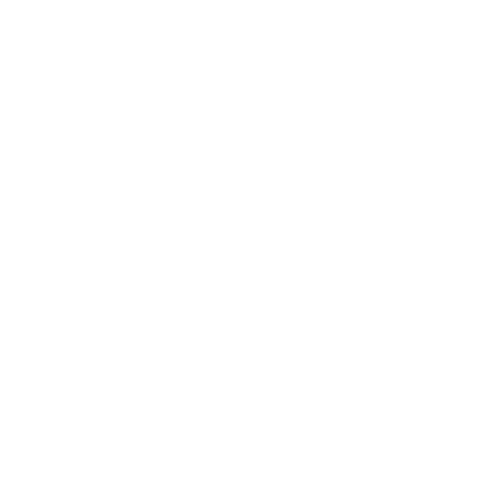

In [6]:
# Create environment map
# Flip the image to make the bottom-left the origin and transpose the y-coordinate (since the image is in [-y][x] coordinates, convert to [x][y] coordinates)
environment_map = np.flip(environment_image, 0)
environment_map = environment_map.transpose()

# Coordinates of the start and goal points
start = [0.5, 0.5]
goal = [4.5, 4.5]

# ============= Main process of A* ===================
# Heuristic weight
# Small weight: High possibility of finding the optimal path, but computation time tends to be longer
# Large weight: Low possibility of finding the optimal path, but computation time tends to be shorter
# Weight = 0: Guaranteed to find the optimal path, but computation time is likely to be long (when weight = 0, it becomes Dijkstra's algorithm. In other words, A* can be said to generalize Dijkstra's algorithm)
heuristic_weight = 1.0 
a_star = AStar(start[0], start[1], goal[0], goal[1], environment_map, m_per_pixel, heuristic_weight, save_animation=True)
path = a_star.planning()
# ================================================

# Draw the path
if path is not None:
    # Draw the path in Pybullet
    pybullet.removeAllUserDebugItems() # Remove existing debug items
    # Since addUserDebugLine requires 3D coordinates, create a 3D path with z-coordinate set to 0.01
    path_3d = []
    for i in range(len(path)):
        path_3d.append([path[i][0], path[i][1], 0.01])
    for i in range(len(path) - 1):
        pybullet.addUserDebugLine(path_3d[i], path_3d[i + 1], [1, 0, 0], lineWidth=5)

# <a id='toc7_'></a>[Bonus: Displaying the Animation](#toc0_)

Display the A* path planning as an animation.

In [7]:
def update(i):
    a_star.image.set_data(a_star.map_image_array[i])
    return a_star.image

# Animate
ani = FuncAnimation(a_star.fig, update, frames=len(a_star.map_image_array), interval=10)
HTML(ani.to_jshtml()) # Convert to HTML
# ani.save('a_star.mp4', writer="ffmpeg") # Save as mp4. Executing this will increase processing time